In [1]:
import os
# suppress tf warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from model import EffNet

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
# enable cuda_malloc_async allocator
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [2]:
image_size = (256, 256)
val_data = '../datasets/images/valid'

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        val_data,
        image_size=image_size,
        batch_size=1,
    )
class_names = val_dataset.class_names
num_classes = len(class_names)

model = EffNet(num_classes=num_classes)
model.build((1, *image_size, 3))

if os.path.exists('../models/effnet.h5'):
    model.load_weights('../models/effnet.h5')
else:
    raise Exception('Model weights not found')

model.summary()

Found 18734 files belonging to 147 classes.
Model: "eff_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Function  (None, None, None, 1280   53150388  
 al)                         )                                   
                                                                 
 global_average_pooling2d (  multiple                  0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               multiple                  75411     
                                                                 
 dense_1 (Dense)             multiple                  524800    
                                                                 
 dense_2 (Dense)             multiple                  1311744   
                                                                 
Total params: 5

1/1 [==============================] - 2s 2s/step


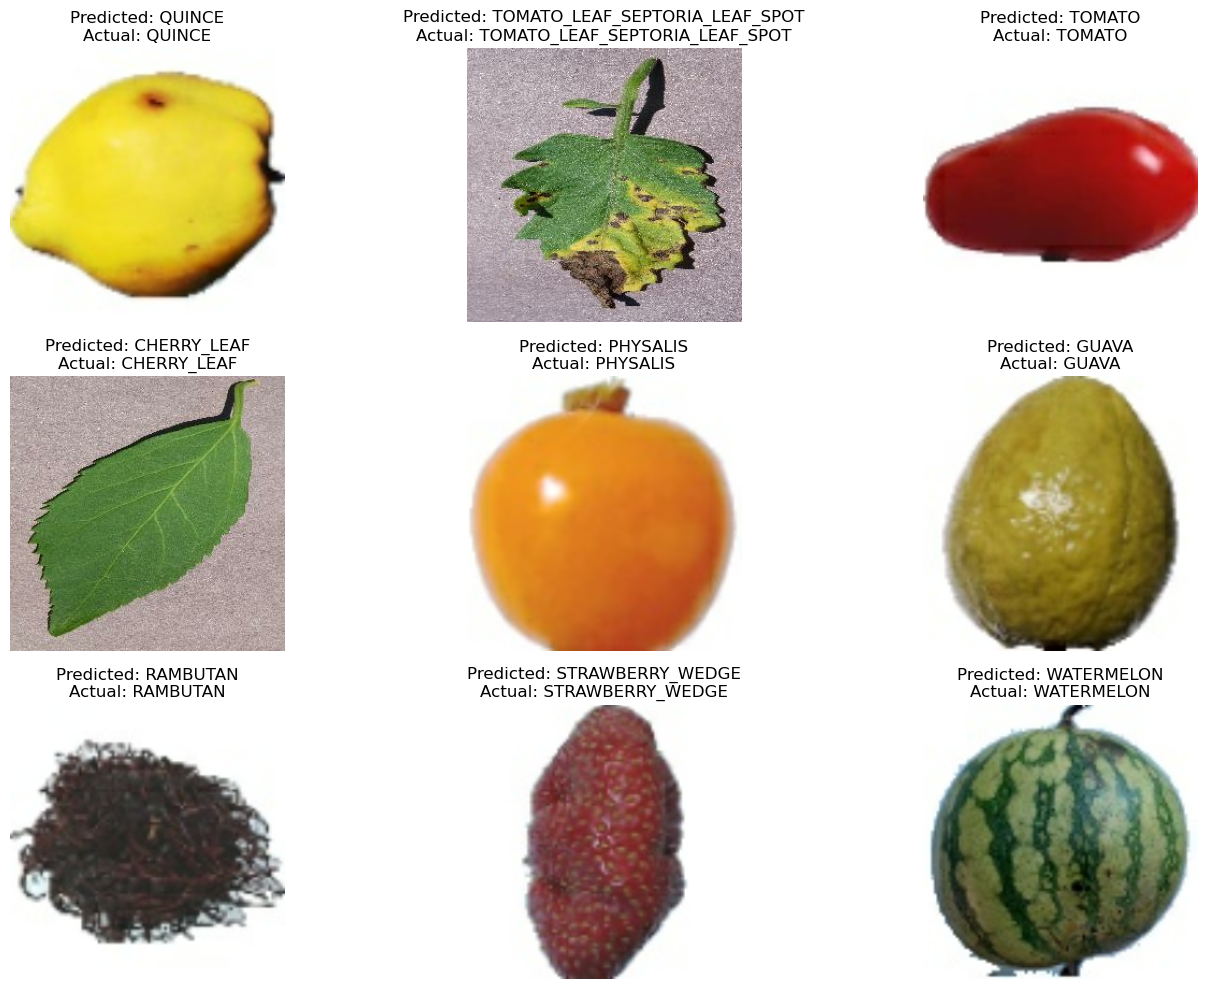

In [3]:
n = 9
X, y = [], []
for image, label in val_dataset.take(n):
    X.extend(image)
    y.extend(label.numpy())
    
y_pred = model.predict(np.array(X))
y_pred = np.argmax(y_pred, axis=1)

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))
for i in range(n):
    ax = axes[i // 3, i % 3]
    ax.imshow(X[i] / 255., cmap='gray')
    ax.set_title(f"Predicted: {class_names[y_pred[i]]}\nActual: {class_names[y[i]]}")
    ax.axis('off')
plt.tight_layout()

In [4]:
from typing import Optional
class ImageResult:
    def __init__(self, class_name, plant_name, disease_name: Optional[str], description: Optional[str]):
        self.class_name = class_name
        self.plant_name = plant_name
        self.disease_name = None if isinstance(disease_name, float) else disease_name
        self.description = None if isinstance(description, float) else description

    def __str__(self):
        out_str = f"Image containing a {self.plant_name.replace('_', ' ').lower()}\n"
        if self.disease_name is not None:
            disease_name = self.disease_name.replace("_", " ").lower()
            out_str += f"with {disease_name} disease\n"
        if self.description is not None:
            out_str += f"image description: {self.description}\n"
        return out_str

In [5]:
import pandas as pd

df = pd.read_csv('../datasets/FARM_HUB.csv')
df.head()

,CLASS,PLANT_NAME,HEALTHY OR DISEASED,DISEASE_NAME,DESCRIPTION,SAMPLE,IN_DATASET
0,APPLE_BRAEBURN,APPLE_BRAEBURN,HEALTHY,NaN,NaN,NaN,✅
1,APPLE_CRIMSON_SHOW,APPLE_CRIMSON_SHOW,HEALTHY,NaN,NaN,NaN,✅
2,APPLE_GOLDEN,APPLE_GOLDEN,HEALTHY,NaN,NaN,NaN,✅
3,APPLE_GRANNY_SMITH,APPLE_GRANNY_SMITH,HEALTHY,NaN,NaN,NaN,✅
4,APPLE_LEAF,APPLE_LEAF,HEALTHY,NaN,-,NaN,✅


1/1 [==============================] - 0s 190ms/step


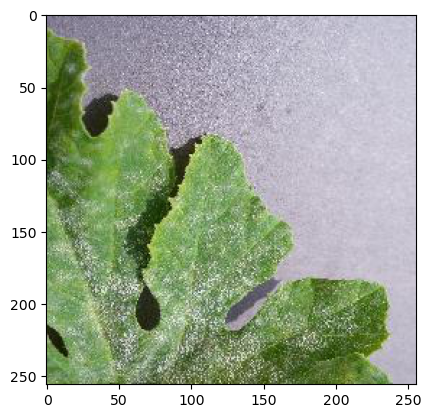

In [6]:
img = tf.keras.preprocessing.image.load_img('../datasets/sample.jpg', target_size=image_size)
img = tf.keras.preprocessing.image.img_to_array(img)
plt.imshow(img / 255.)
pred = model.predict(np.array([img]))
pred = np.argmax(pred, axis=1)

In [7]:
i = pred[0]

ir = ImageResult(
    class_name=df.iloc[i]['CLASS'],
    plant_name=df.iloc[i]['PLANT_NAME'],
    disease_name=df.iloc[i]['DISEASE_NAME'],
    description=df.iloc[i]['DESCRIPTION']
)
print(ir)

Image containing a squash leaf
with powdery mildew disease
image description: a fungal disease that appears as white, powdery patches on the leaves and stems, potentially reducing fruit production and overall plant health.
